### Importing Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

#### Importing the Data

In [3]:
# df = pd.read_csv('..\Data\Train_TEC_mar17.csv')
df = pd.read_csv('../Data/TotalWithMissing.csv')

In [7]:
for i in range(14400,21600):
    df.TEC[i] = 0.0

C:\Users\yash\Miniconda3\envs\TEC\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
df[14395:14405]

,Date,Month,Year,Time,LT,TEC
14395,20,3,2017,23.849722,29.144887,1.717251
14396,20,3,2017,23.883056,29.178223,1.653964
14397,20,3,2017,23.916389,29.211560,1.315151
14398,20,3,2017,23.949722,29.244896,1.293472
14399,20,3,2017,23.983056,29.278233,1.633741
14400,21,3,2017,0.016389,5.311570,0.000000
14401,21,3,2017,0.049722,5.344906,0.000000
14402,21,3,2017,0.083056,5.378243,0.000000
14403,21,3,2017,0.116389,5.411580,0.000000
14404,21,3,2017,0.149722,5.444917,0.000000


#### Dropping Useless columns

In [10]:
df.drop(["Date","Month","Year","Time","LT"], axis = 1, inplace = True)

KeyError: "['Date' 'Month' 'Year' 'Time' 'LT'] not found in axis"

In [12]:
df.fillna(0, inplace=True)
df

,TEC
0,2.067562
1,2.082707
2,2.004272
3,1.736569
4,1.758503
...,...
22315,0.000000
22316,0.000000
22317,0.000000
22318,0.000000


In [41]:
df.head()

,TEC
0,2.067562
1,2.082707
2,2.004272
3,1.736569
4,1.758503


#### Converting it into a ndarray

In [15]:
training_set = df.iloc[:,:].values
training_set

array([[2.06756223],
       [2.08270718],
       [2.00427205],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [16]:
type(training_set), training_set.shape

(numpy.ndarray, (22320, 1))

#### Plotting the Data

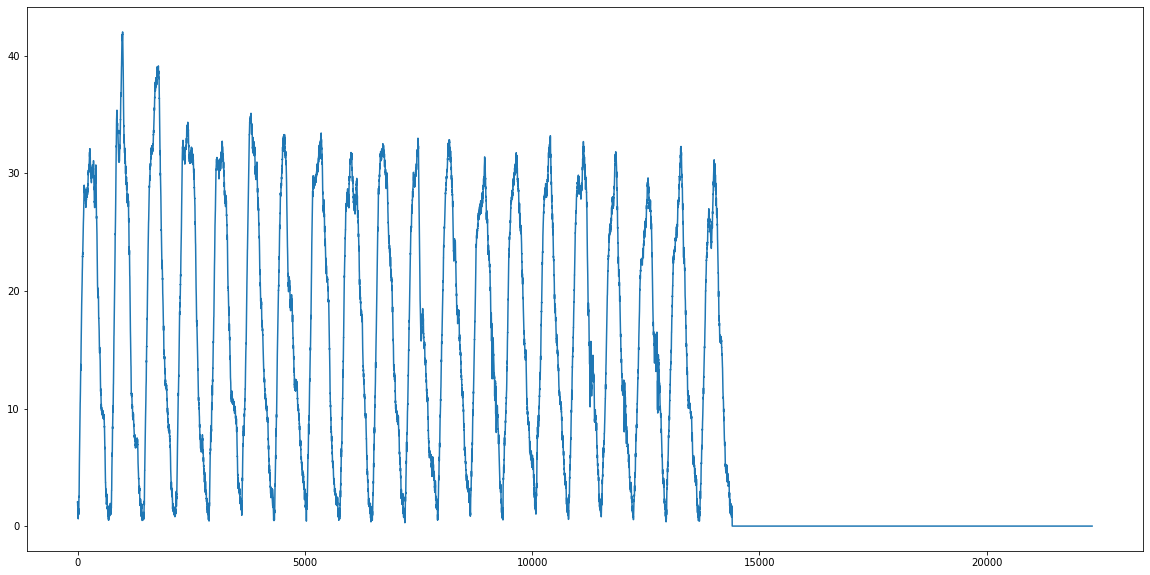

In [17]:
plt.figure(figsize=(20,10))

plt.plot(training_set, label = 'TEC Values')
plt.show()

#### Making Data Sequential for look back

In [36]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()

training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.65)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [48]:
len(y)

22315

In [38]:
training_data[-5:],x[0].shape, x[0], x[1], y

(array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 (4, 1),
 array([[0.04918105],
        [0.0495413 ],
        [0.04767557],
        [0.04130773]]),
 array([[0.0495413 ],
        [0.04767557],
        [0.04130773],
        [0.04182947]]),
 array([[0.04182947],
        [0.03685276],
        [0.04142007],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]))

In [39]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [40]:
# num_epochs = 1000
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()   
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 1 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.25300
Epoch: 1, loss: 0.23526
Epoch: 2, loss: 0.21780
Epoch: 3, loss: 0.20072
Epoch: 4, loss: 0.18413
Epoch: 5, loss: 0.16813
Epoch: 6, loss: 0.15285
Epoch: 7, loss: 0.13842
Epoch: 8, loss: 0.12496
Epoch: 9, loss: 0.11262
Epoch: 10, loss: 0.10151
Epoch: 11, loss: 0.09175
Epoch: 12, loss: 0.08345
Epoch: 13, loss: 0.07665
Epoch: 14, loss: 0.07138
Epoch: 15, loss: 0.06761
Epoch: 16, loss: 0.06523
Epoch: 17, loss: 0.06408
Epoch: 18, loss: 0.06393
Epoch: 19, loss: 0.06448
Epoch: 20, loss: 0.06542
Epoch: 21, loss: 0.06644
Epoch: 22, loss: 0.06727
Epoch: 23, loss: 0.06769
Epoch: 24, loss: 0.06758
Epoch: 25, loss: 0.06691
Epoch: 26, loss: 0.06571
Epoch: 27, loss: 0.06406
Epoch: 28, loss: 0.06209
Epoch: 29, loss: 0.05994
Epoch: 30, loss: 0.05773
Epoch: 31, loss: 0.05558
Epoch: 32, loss: 0.05359
Epoch: 33, loss: 0.05180
Epoch: 34, loss: 0.05026
Epoch: 35, loss: 0.04897
Epoch: 36, loss: 0.04789
Epoch: 37, loss: 0.04701
Epoch: 38, loss: 0.04625
Epoch: 39, loss: 0.04558
Epoch: 40,

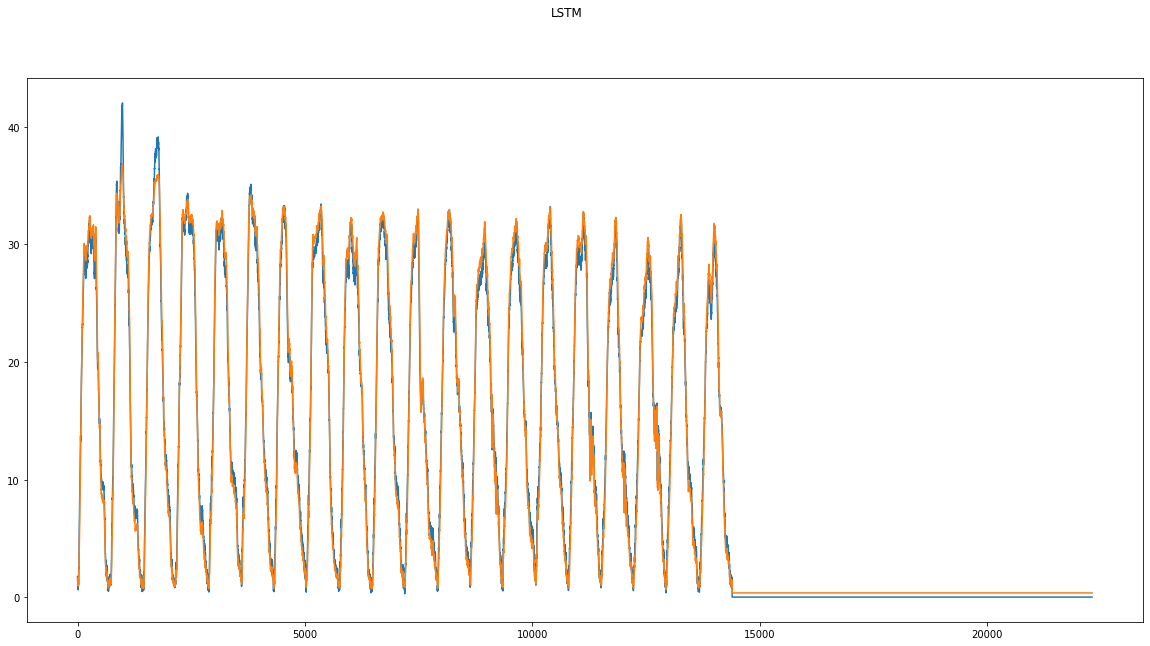

In [41]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(20,10))

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('LSTM')
plt.show()

In [42]:
train_predict.shape

torch.Size([22315, 1])

In [43]:
dataY_plot.shape

(22315, 1)

In [44]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(dataY_plot, data_predict))

rms

0.8715225327643381